# Table of contents

1. [Importing Required Packages](#packages)
2. [Importing Dataset](#dataset)
3. [Analyzing the dataset](#analyzing)


# Importing Required Packages


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import yfinance as yf

In [2]:
pd.options.mode.copy_on_write = True

# Importing Dataset


In [3]:
start_date = "2022-07-01"
end_date = "2024-03-15"
data = yf.download("CIB", start=start_date, end=end_date)
data = data.resample("D").ffill()

[*********************100%%**********************]  1 of 1 completed


In [4]:
df = data[["Close"]]

## Analyzing the dataset


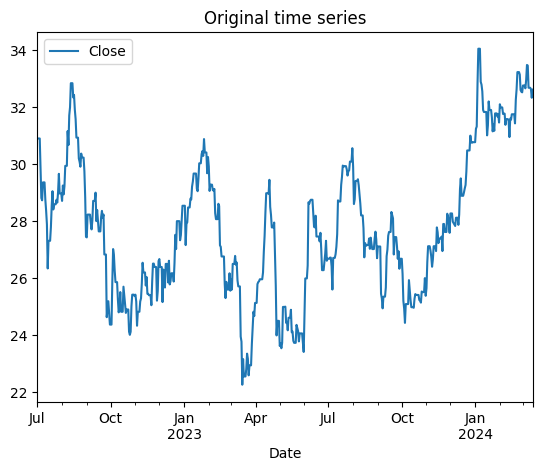

In [5]:
df.plot()
plt.title("Original time series")
plt.show()

El gráfico sugiere que no hay una estacionalidad evidente y que existe una tendencia a la alza en el precio de la acción de NVDA.
Se identifican fluctuaciones irregulares en el precio de la acción de NVDA. No es por causas aleatorias sino por la creciente demanda de GPUs para la minería de criptomonedas y entrenamiento de modelos LLM.


<Figure size 1000x600 with 0 Axes>

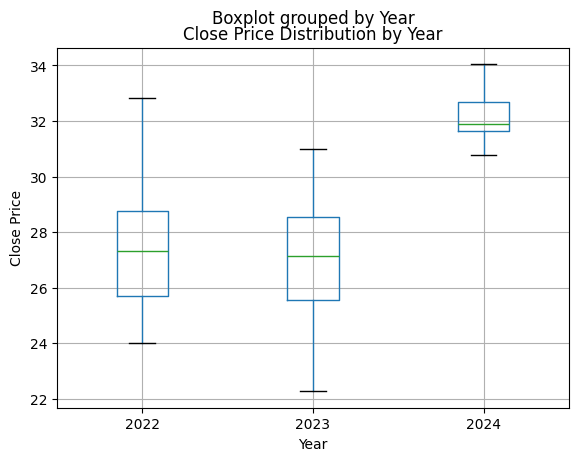

In [6]:
data["Year"] = df.index.year
plt.figure(figsize=(10, 6))
data.boxplot(column="Close", by="Year")
plt.title("Close Price Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Close Price")
plt.show()

Según el comportamiento de los boxplots, se observa que el precio de la acción de NVDA ha ido en aumento a lo largo del tiempo. Y también la varianza ha aumentado a lo largo del tiempo.


# Train Test Split


In [7]:
test_size = 15
df_length = len(df)

In [8]:
train_df = df.iloc[: (df_length - test_size - 1)]
test_df = df.iloc[(df_length - test_size) :]
display(train_df.tail())

,Close
Date,
2024-02-23,33.230000
2024-02-24,33.230000
2024-02-25,33.230000
2024-02-26,33.139999
2024-02-27,32.599998


In [9]:
display(test_df.head())

,Close
Date,
2024-02-29,32.520000
2024-03-01,32.759998
2024-03-02,32.759998
2024-03-03,32.759998
2024-03-04,32.660000


# Stationarity


In this section, we check the series for its stationarity, and transform the series to stationary if it ends up being non stationary. For this a helper function is defined below that plots ACF and PACF plots of the series given to it as input.


In [10]:
def plot_acf_pacf(df):
    plt.rcParams["figure.figsize"] = 18, 5

    _, axes = plt.subplots(1, 2)

    sgt.plot_acf(df["Close"], zero=False, lags=40, ax=axes[0])
    sgt.plot_pacf(df["Close"], zero=False, lags=40, ax=axes[1])

    plt.show()

In [11]:
def calculate_adf_test(df):
    print("ADF Test:")
    print(adfuller(df["Close"]))

For checking the stationarity, we plot the **ACF** and **PACF** plots of the series, and run the **ADF** test.


## Original Series Stationarity Check


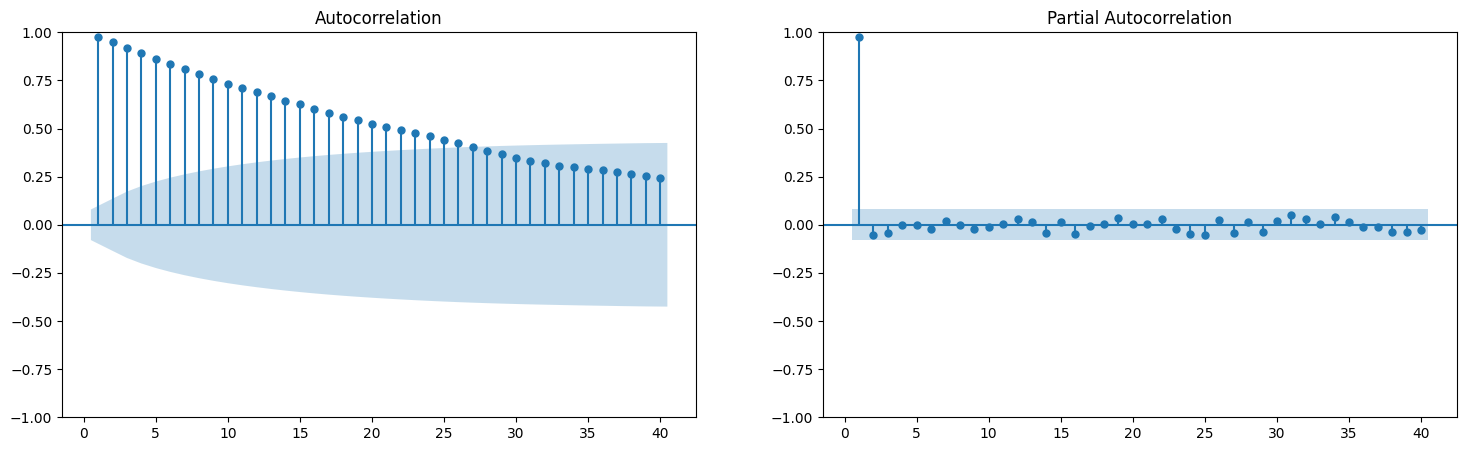

ADF Test:
(-2.256564573548289, 0.18635947727660673, 0, 606, {'1%': -3.4411869900487906, '5%': -2.866321181236609, '10%': -2.569316262893616}, 804.6832133240517)


In [12]:
plot_acf_pacf(train_df)
calculate_adf_test(train_df)

## Transformation Techniques


Clearly this series is **Non-Stationary**. So before applying the ARIMA Models, we tranform this series to Stationary using the following transofrmations.

- **Log Transformation**: Taking the log of each data point will dampen the effect of variance over time
- **Differencing**: Taking the difference between consecutive data points usually removes the trend changes over time.
- **Log Tranformation** followed by **Differencing**: This technique removes both mean and variance changes over time.


To see which tranformation works best for our use case, lets plot the data and its summary statistics over time.


In [13]:
def smoother(df, window=100, column="Close"):
    rolling_mean = df[column].rolling(window).mean()
    rolling_var = df[column].rolling(window).var()
    return rolling_mean, rolling_var

In [14]:
def plot_rolling_mean_and_rolling_var(
    df, window=100, rolling_mean_title="", rolling_variance_title="", column="Close"
):
    df.plot(y=column, use_index=True)
    plt.ylabel(column)
    plt.title(f"Plot of the column '{column}'")
    plt.show()

    plot_acf_pacf(df)

    rolling_mean, rolling_var = smoother(df, window=window, column=column)

    _, (ax1, ax2) = plt.subplots(1, 2)
    plt.rcParams["figure.figsize"] = 18, 12

    ax1.plot(rolling_mean)
    if rolling_mean_title:
        ax1.set_title(rolling_mean_title)
    else:
        ax1.set_title(f"Rolling Mean (Window = {window_size})")

    ax2.plot(rolling_var)
    if rolling_variance_title:
        ax2.set_title(rolling_variance_title)
    else:
        ax2.set_title(f"Rolling Variance (Window = {window_size})")

    plt.show()

    calculate_adf_test(df)

In [15]:
window_size = 30

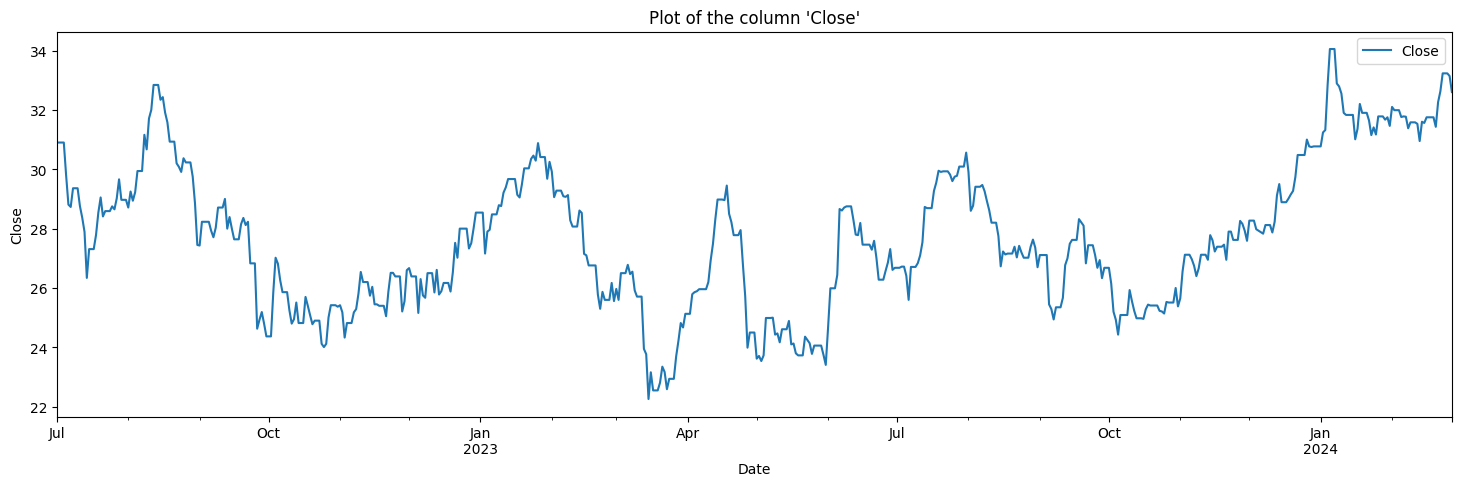

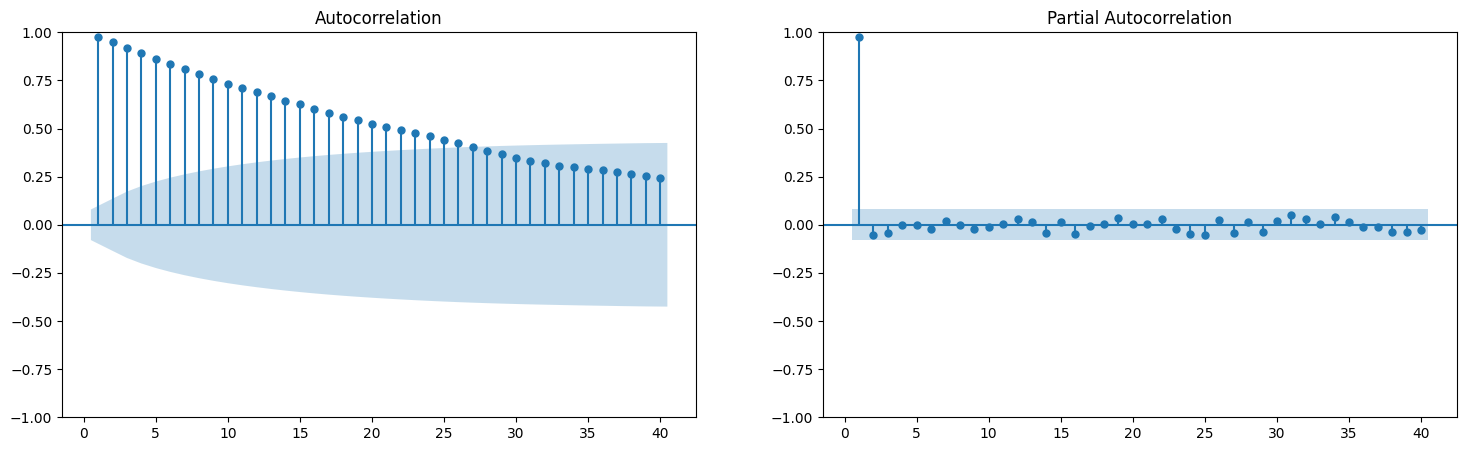

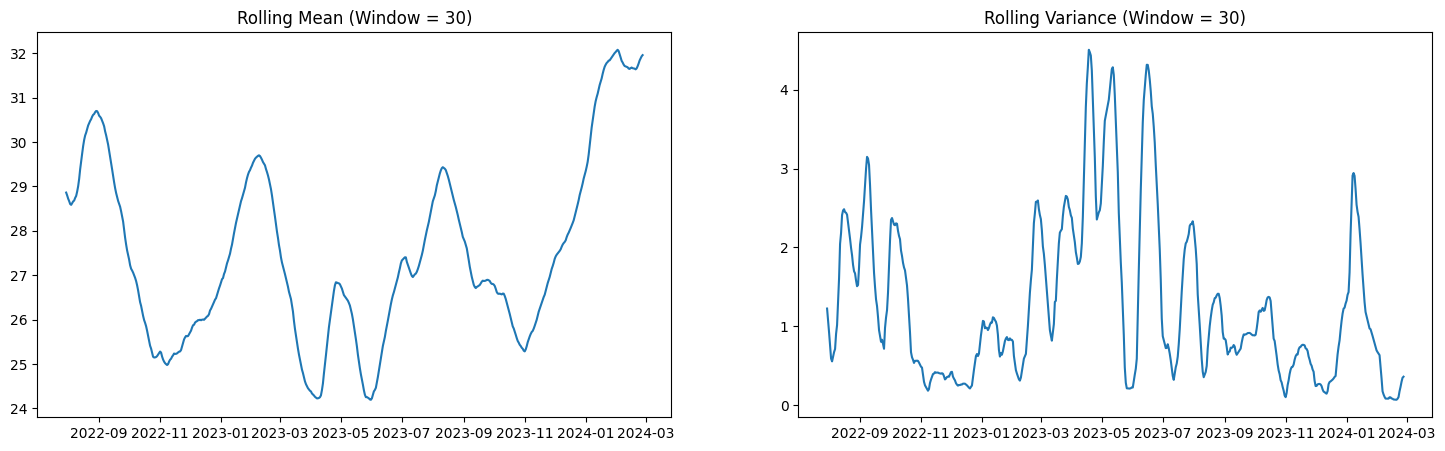

ADF Test:
(-2.256564573548289, 0.18635947727660673, 0, 606, {'1%': -3.4411869900487906, '5%': -2.866321181236609, '10%': -2.569316262893616}, 804.6832133240517)


In [16]:
plot_rolling_mean_and_rolling_var(train_df, window_size)

From these plots its obvious that the mean and variance in the data varies with respect to time. The 3 transformation techniques listed above are applied in the following cells.


### Log Transformation


$y\_new_t = \log(y_t)$

where,

- $y\_new_t$: Transformed Series at time $t$
- $y_t$: Original Series at time $t$


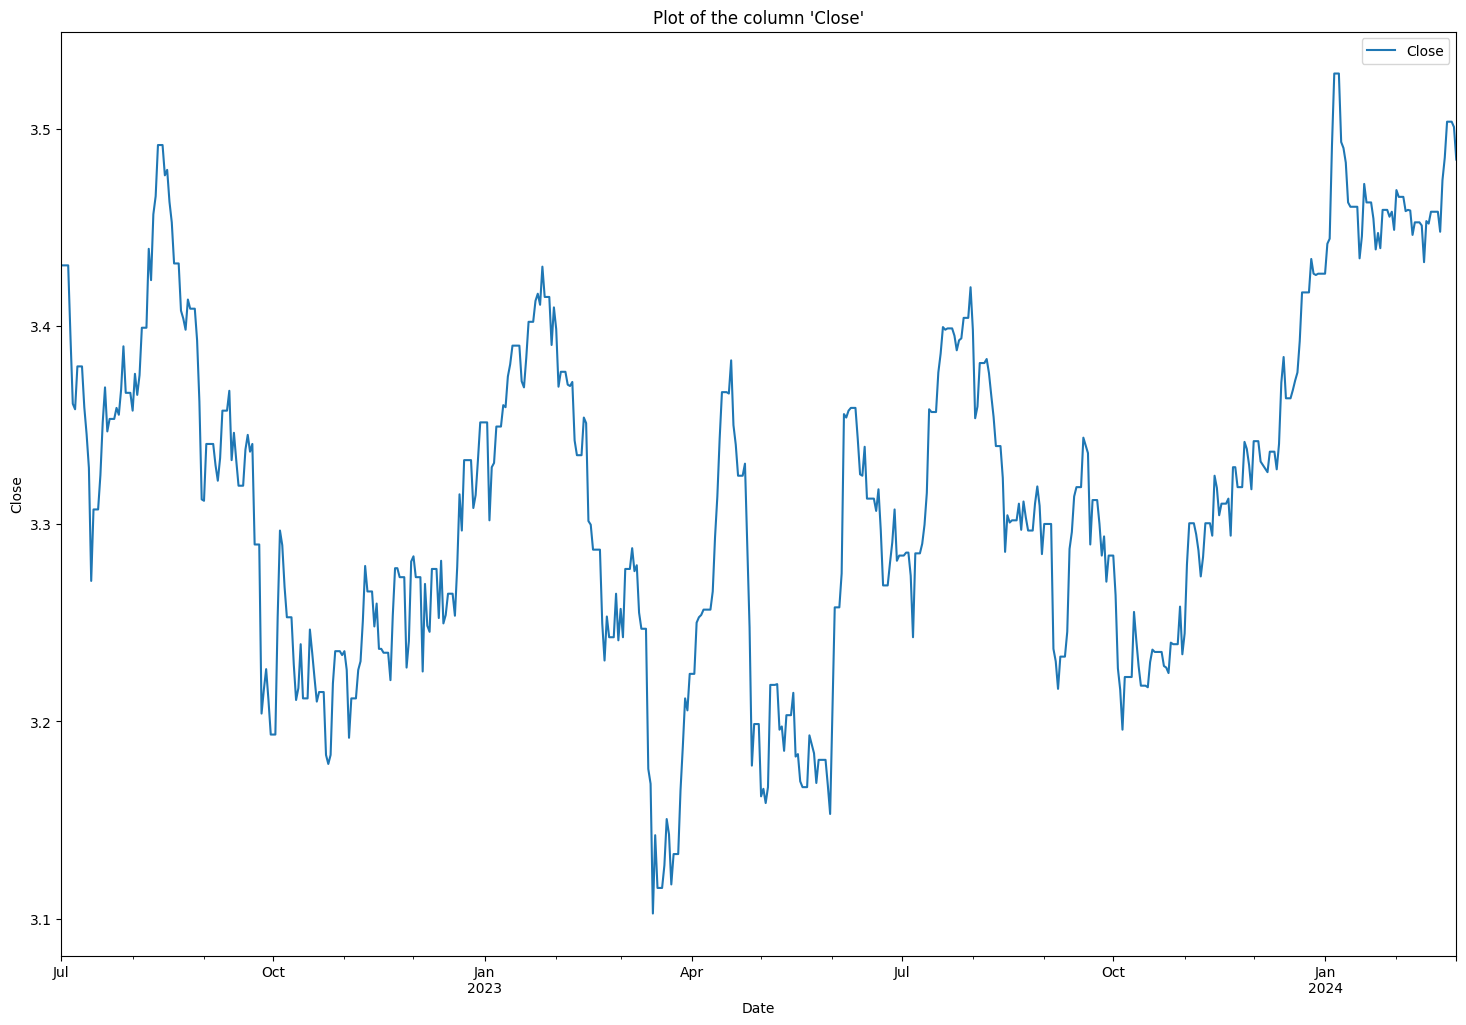

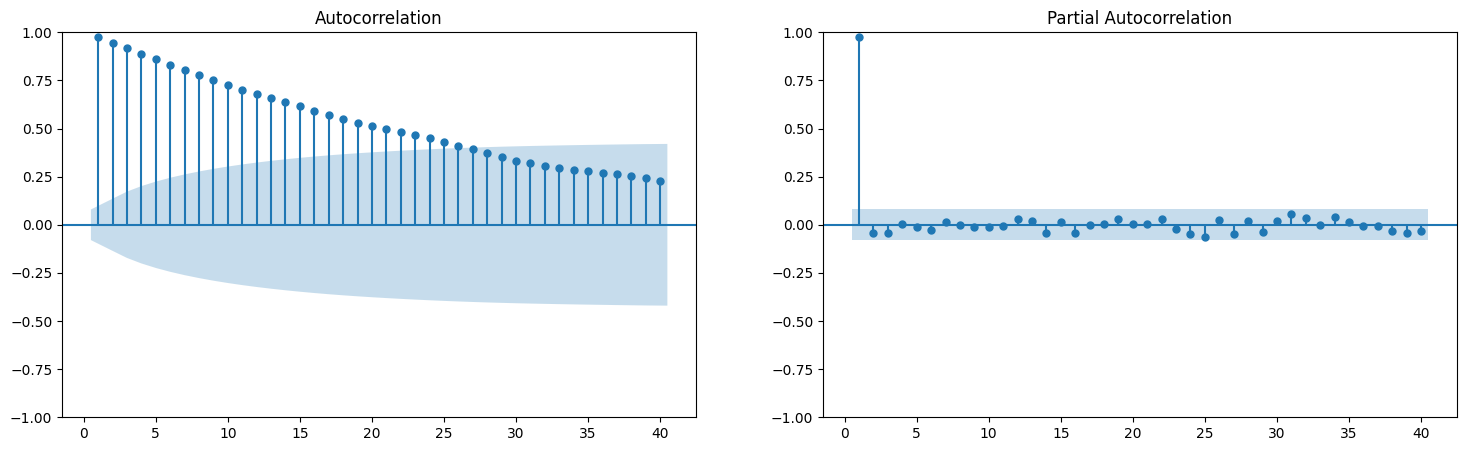

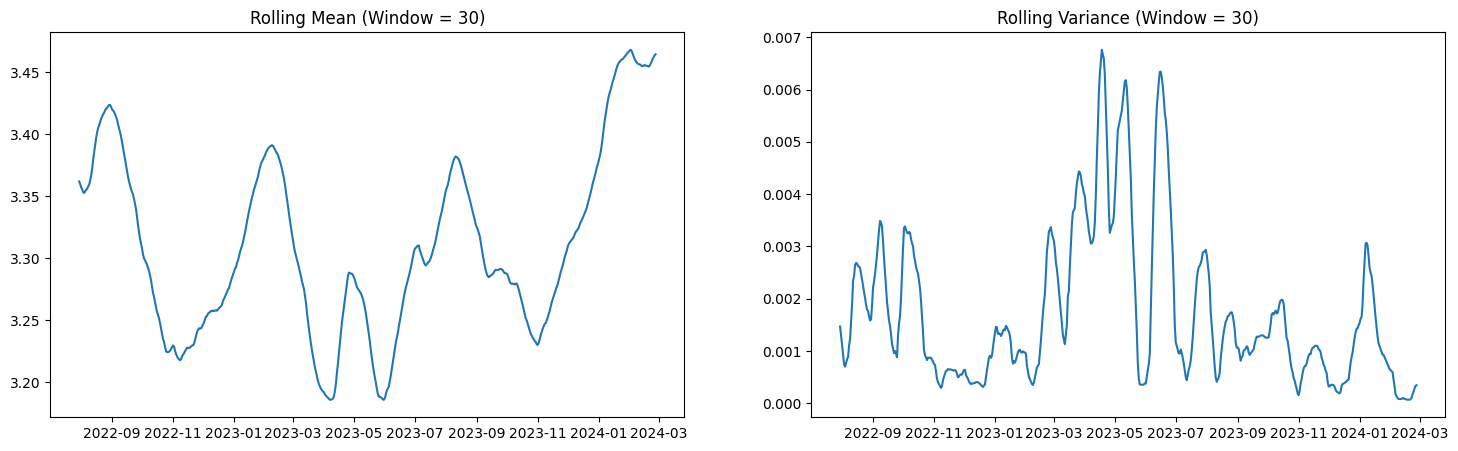

ADF Test:
(-2.3750499619326457, 0.1489025404581532, 0, 606, {'1%': -3.4411869900487906, '5%': -2.866321181236609, '10%': -2.569316262893616}, -3063.100800665626)


In [17]:
train_df_log_transformation = train_df.copy()
train_df_log_transformation["Close"] = np.log(train_df["Close"])
plot_rolling_mean_and_rolling_var(train_df_log_transformation, window_size)

Using the **Log Transform**, the non stationarity of the dataset could not be removed in this case.


### Differencing


$y\_new_t = y_t - y_{t-1}$

where,

- $y\_new_t$: Transformed Series at time $t$
- $y_t$: Original Series at time $t$
- $y_{t-1}$: Original Series at time $t-1$


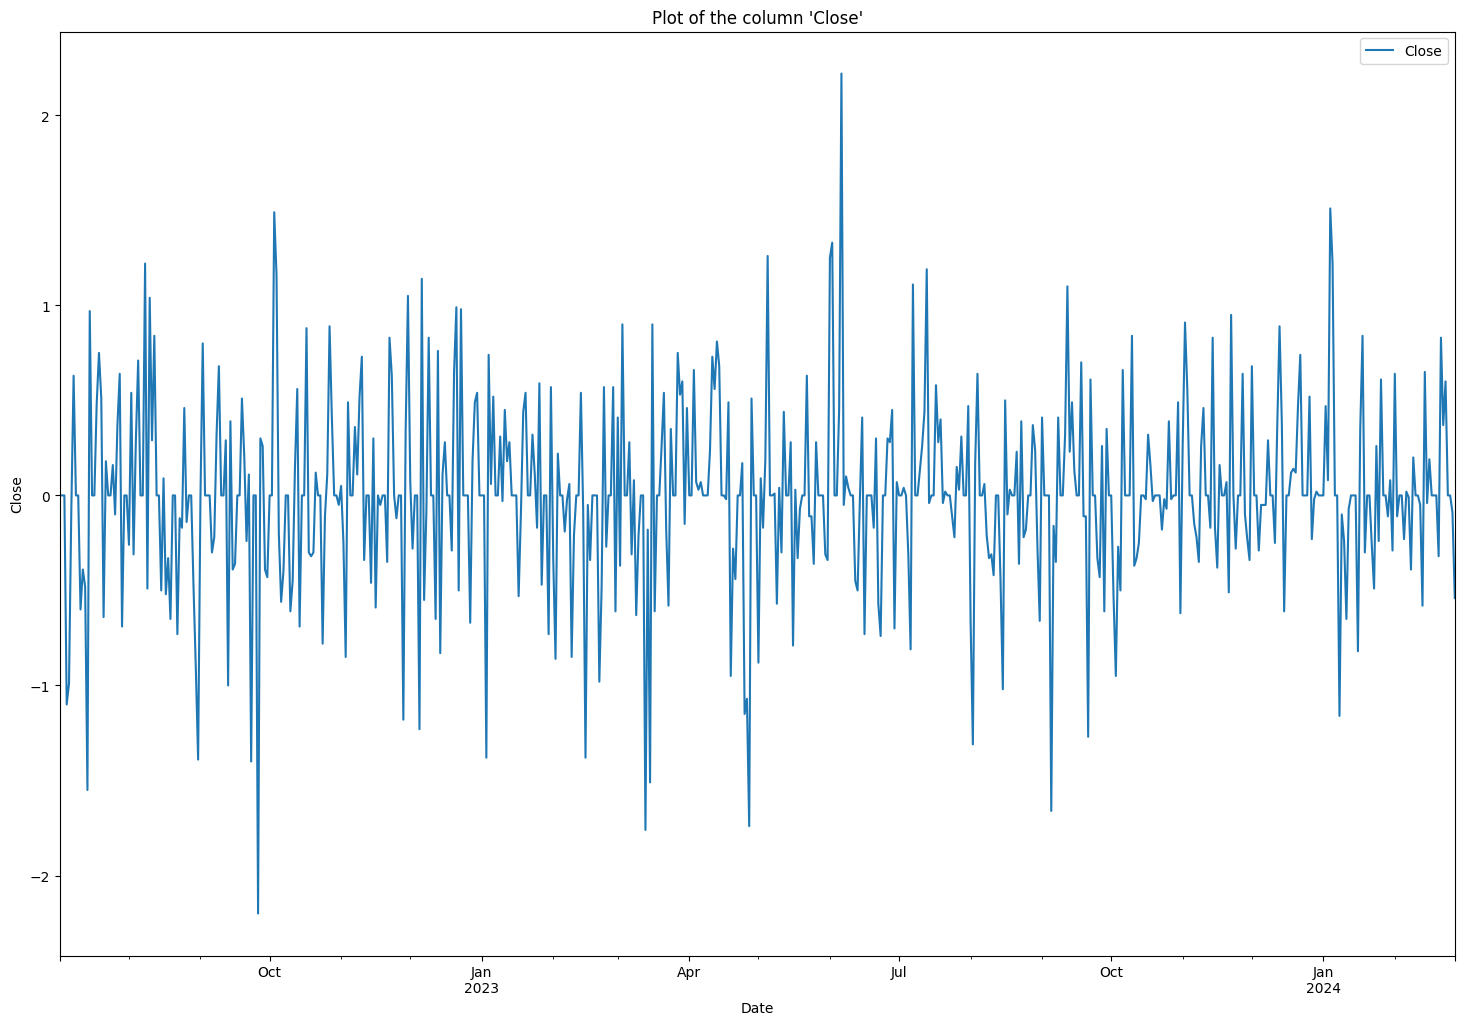

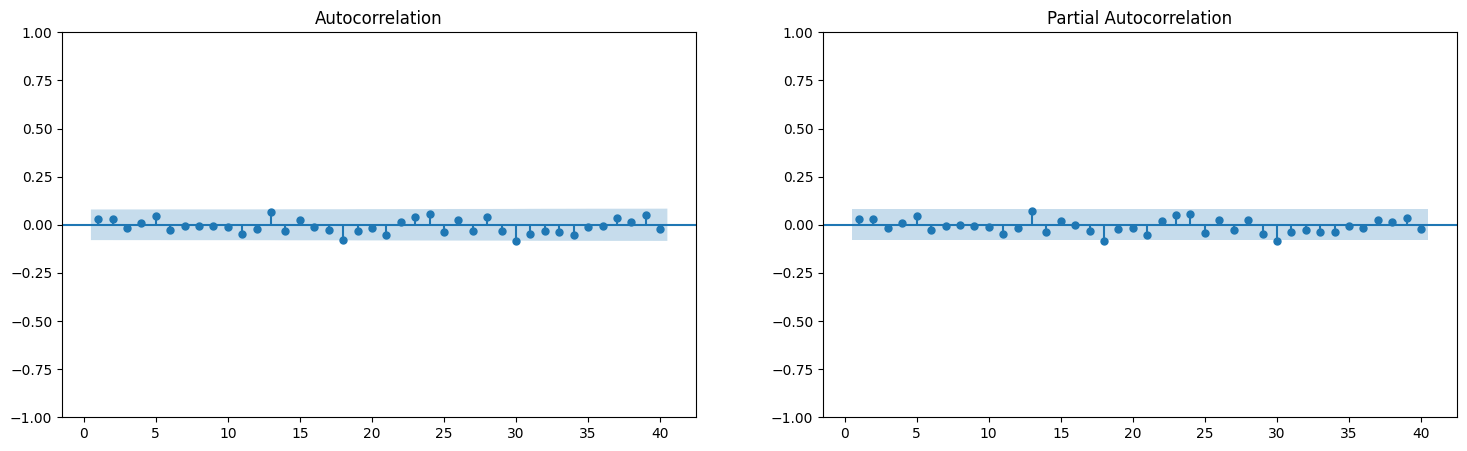

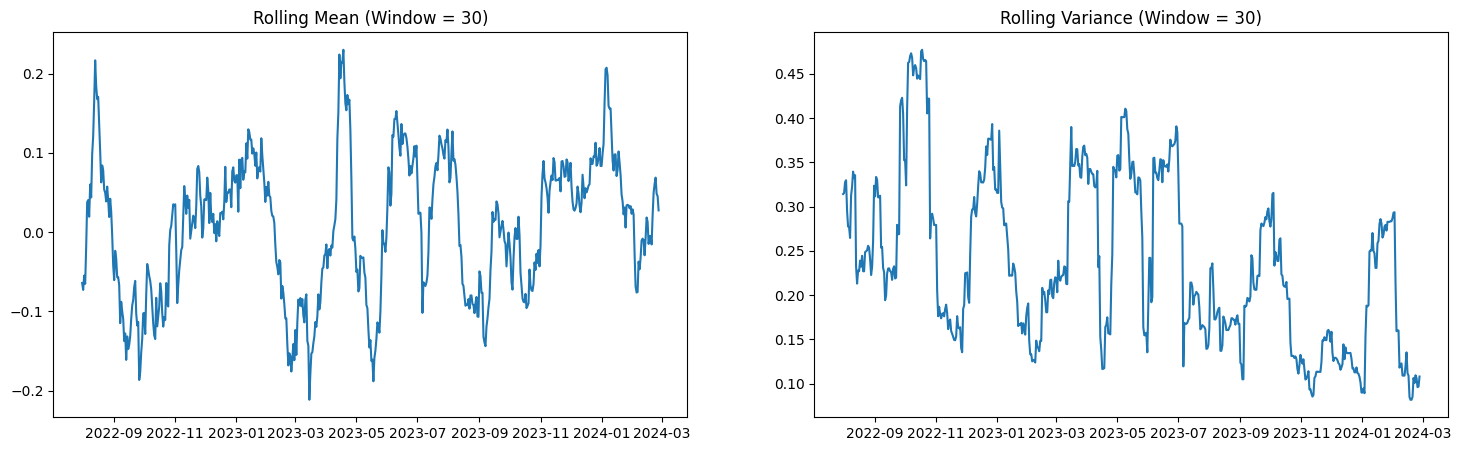

ADF Test:
(-23.816888640907237, 0.0, 0, 605, {'1%': -3.441204979288887, '5%': -2.86632910370007, '10%': -2.56932048425654}, 806.2325777215057)


In [18]:
train_df_diff = train_df.copy()
train_df_diff["Close"] = train_df_diff["Close"].diff(1)
train_df_diff.dropna(inplace=True)
plot_rolling_mean_and_rolling_var(train_df_diff, window_size)

Clearly the series has been transformed to stationary. But since the variance of the series was also time dependent, transforming the data using **Log Transform** followed by **Differencing** seems ideal.


### Log Transform followed by Differencing


$y\_LT_t = \log(y_t)$<br>
$y\_LT_{t-1} = \log(y_{t-1})$

$y\_new_t = y\_LT_t - y\_LT_{t-1}$<br>
$y\_new_t = \log(y_t) - \log(y_{t-1})$

$\therefore y\_new_t = \log(y_t / y_{t-1})$

where,

- $y\_LT_t$: Log Transformed Series at time $t$
- $y\_LT_{t-1}$: Log Transformed Series at time $t-1$
- $y\_new_t$: Final Differenced Transformed Series at time $t$
- $y_t$: Original Series at time $t$
- $y_{t-1}$: Original Series at time $t-1$


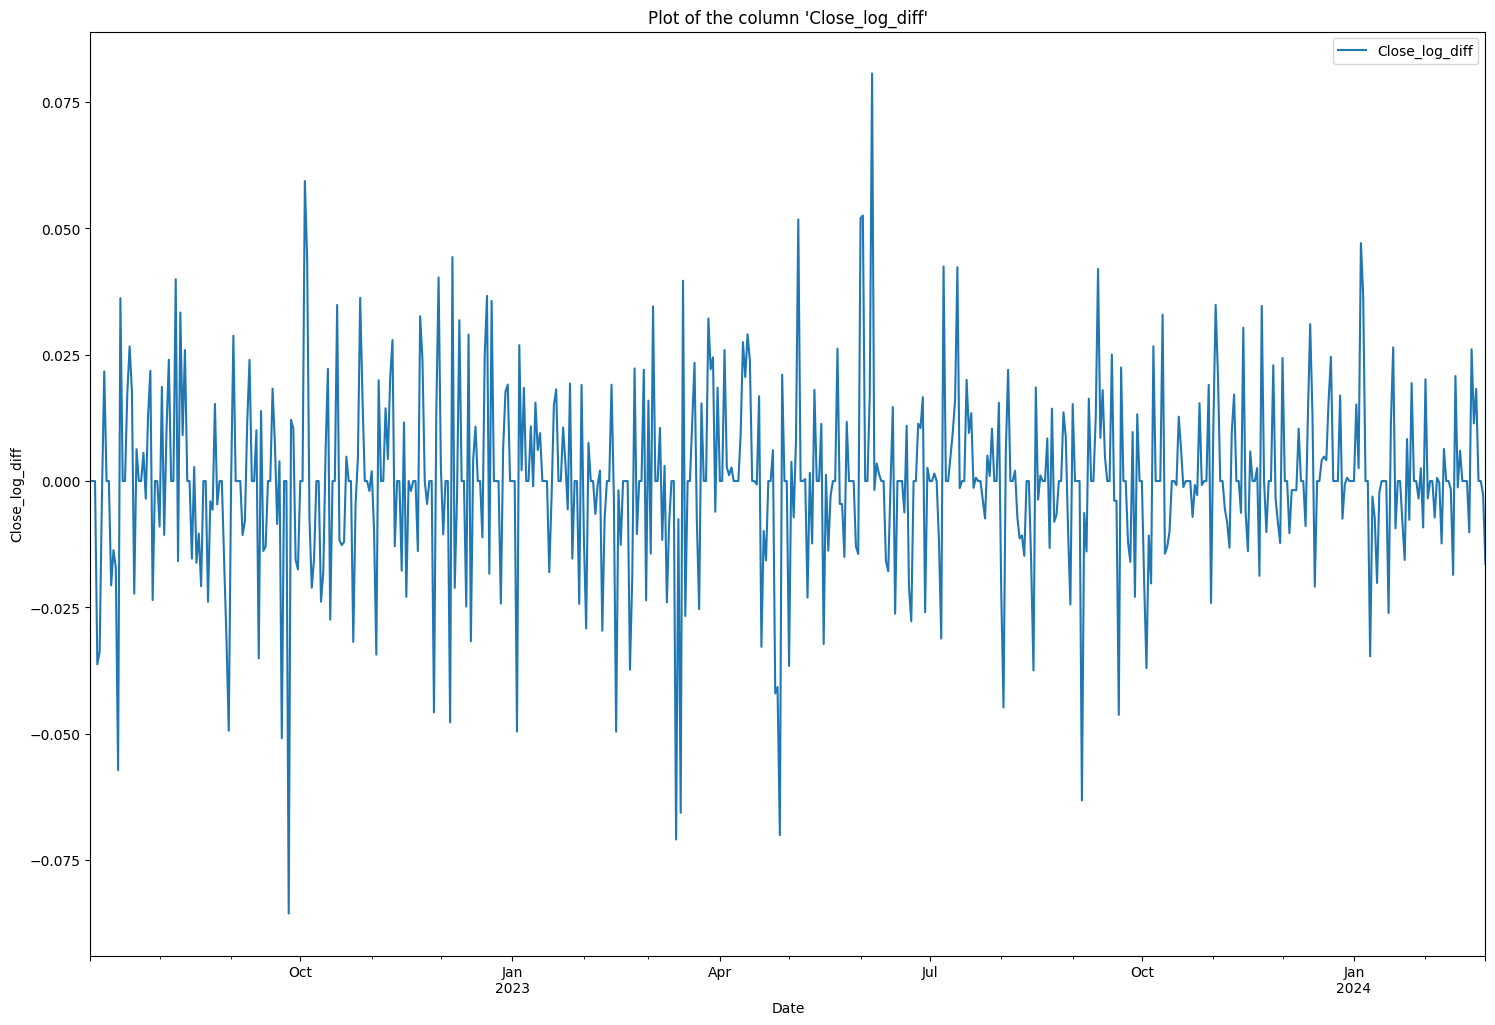

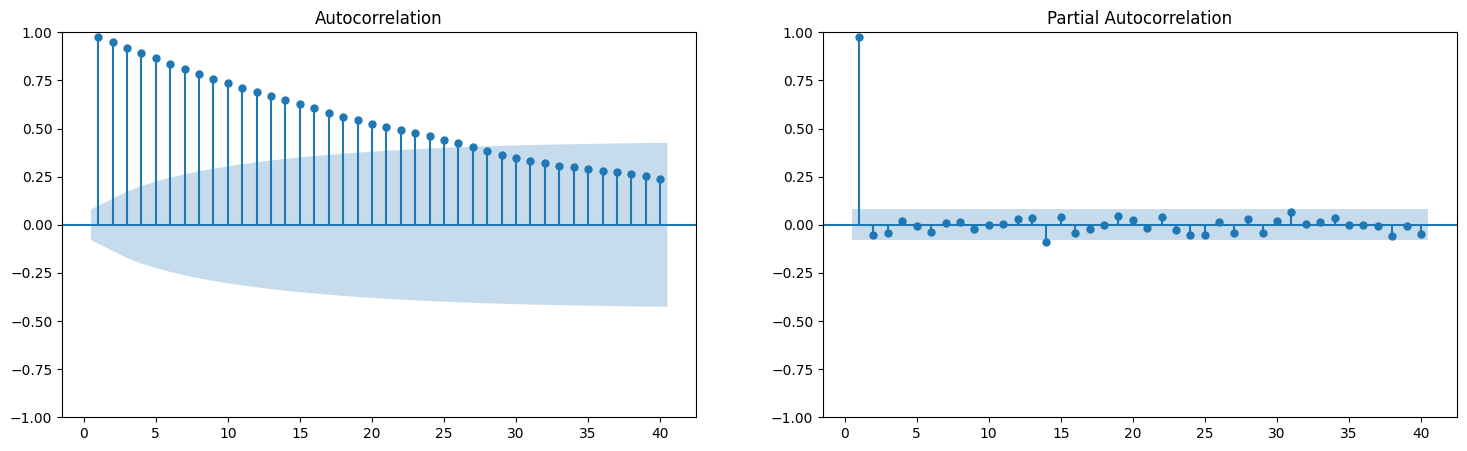

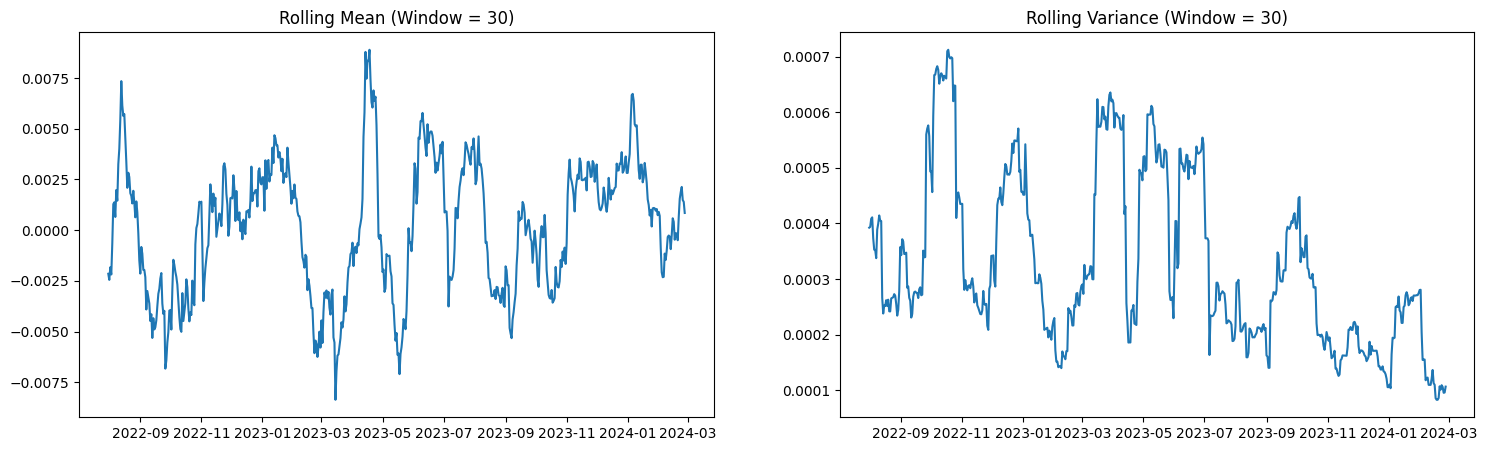

ADF Test:
(-2.257865159007123, 0.1859174411917091, 0, 605, {'1%': -3.441204979288887, '5%': -2.86632910370007, '10%': -2.56932048425654}, 802.625078451447)


In [19]:
train_df_log_diff = train_df.copy()
train_df_log_diff["Close_log_diff"] = np.log(train_df_log_diff["Close"])
train_df_log_diff["Close_log_diff"] = train_df_log_diff["Close_log_diff"].diff(1)
train_df_log_diff.dropna(inplace=True)

plot_rolling_mean_and_rolling_var(
    train_df_log_diff, window_size, column="Close_log_diff"
)

Clearly, this series is stationary and hence, it is the series that will be used to fit the model. Looking at the **ACF** and **PACF** plots for this transformed series, it is reasonalble to start building an **ARMA** Model with the following parameters -

- p = 1 or p = 2 (first 2 lags are significant in PACF plot)
- d = 0 (series is stationary)
- q = 1 or q = 2 (first 2 lags are significant in ACF plot)

If seasonal model (**SARMA**) is to be considered, then the following parameters could be added to the model.

- m = 5 (being a market index, the data is most likely to have weekly repeating patterns as seen in Visualization)
- P = 1 (5th lag is significant in PACF plot)
- D = 0
- Q = 1 (5th lag is significant in ACF plot)


# Model Building


## Naive model


In [20]:
# walk-forward validation
history = [x for x in train_df["Close"]]
predictions = list()
for i in range(len(test_df)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test_df.iloc[i].values[0]
    history.append(obs)
# report performance

values = sum(test_df.values.tolist(), [])
mape = mean_absolute_percentage_error(values, predictions)
rmse = sqrt(mean_squared_error(values, predictions))
print("Naive approach:")
print(f"RMSE: {rmse}")
print(f"MAPE: {round(mape*100, 2)}%")

Naive approach:
RMSE: 0.29076830724490615
MAPE: 0.59%


## ARIMA model (1, 1, 0)


In [21]:
def evaluate_arima_model(arima_order, column="Close"):
    history = list(np.log(train_df[column]))
    predictions = list()

    for i in range(len(test_df)):
        # predict
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # observation
        obs = test_df.iloc[i].values[0]
        history.append(np.log(obs))
    # report performance
    values = sum(test_df.values.tolist(), [])
    predictions = np.exp(predictions)
    mape = mean_absolute_percentage_error(values, predictions)
    rmse = sqrt(mean_squared_error(values, predictions))
    print(f"ARIMA Order: {arima_order}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {round(mape*100, 2)}%")
    return mape, rmse, predictions

In [22]:
evaluate_arima_model((1, 1, 0))

ARIMA Order: (1, 1, 0)
RMSE: 0.2907661130238416
MAPE: 0.6%


(0.005954090597848786,
 0.2907661130238416,
 array([32.58946125, 32.51841397, 32.76475937, 32.75999832, 32.75999832,
        32.65802713, 32.965911  , 33.4906588 , 33.45959394, 32.66432955,
        32.68000031, 32.68000031, 32.62898802, 32.323926  , 32.62580243]))

## Grid search


In [23]:
best_score, best_order = float("inf"), None

p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mape, rmse, _ = evaluate_arima_model(order)
                if mape < best_score:
                    best_score, best_order = mape, order
                print(f"ARIMA: {order} --- MAPE: {mape} --- RMSE: {rmse}")
            except:
                continue
print(f"Best ARIMA: {best_order} --- Best MAPE: {round(best_score*100, 2)}%")

ARIMA Order: (0, 0, 0)
RMSE: 5.174864580787881
MAPE: 15.76%
ARIMA: (0, 0, 0) --- MAPE: 0.15757648128376694 --- RMSE: 5.174864580787881


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (0, 0, 1)
RMSE: 2.7444688589975463
MAPE: 8.19%
ARIMA: (0, 0, 1) --- MAPE: 0.08192359966596965 --- RMSE: 2.7444688589975463


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order: (0, 0, 2)
RMSE: 1.8956907556016225
MAPE: 5.72%
ARIMA: (0, 0, 2) --- MAPE: 0.05723798896349191 --- RMSE: 1.8956907556016225
ARIMA Order: (0, 1, 0)
RMSE: 0.29076830724490704
MAPE: 0.59%
ARIMA: (0, 1, 0) --- MAPE: 0.005895907574730647 --- RMSE: 0.29076830724490704


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (0, 1, 1)
RMSE: 0.29071587814027877
MAPE: 0.6%
ARIMA: (0, 1, 1) --- MAPE: 0.0059543862478866234 --- RMSE: 0.29071587814027877
ARIMA Order: (0, 1, 2)
RMSE: 0.2947908053915314
MAPE: 0.61%
ARIMA: (0, 1, 2) --- MAPE: 0.00607146631371819 --- RMSE: 0.2947908053915314


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (0, 2, 0)
RMSE: 0.42523773173751017
MAPE: 1.06%
ARIMA: (0, 2, 0) --- MAPE: 0.010582389735889002 --- RMSE: 0.42523773173751017


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (0, 2, 1)
RMSE: 0.2912228995985232
MAPE: 0.6%
ARIMA: (0, 2, 1) --- MAPE: 0.005979113822303805 --- RMSE: 0.2912228995985232


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood 

ARIMA Order: (0, 2, 2)
RMSE: 0.2911028856552911
MAPE: 0.6%
ARIMA: (0, 2, 2) --- MAPE: 0.005993569591682809 --- RMSE: 0.2911028856552911


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (1, 0, 0)
RMSE: 0.30056522336104313
MAPE: 0.66%
ARIMA: (1, 0, 0) --- MAPE: 0.006626456073319512 --- RMSE: 0.30056522336104313
ARIMA Order: (1, 0, 1)
RMSE: 0.3018830192521458
MAPE: 0.68%
ARIMA: (1, 0, 1) --- MAPE: 0.006751279642629714 --- RMSE: 0.3018830192521458
ARIMA Order: (1, 0, 2)
RMSE: 0.306819695718076
MAPE: 0.68%
ARIMA: (1, 0, 2) --- MAPE: 0.006817848321222239 --- RMSE: 0.306819695718076
ARIMA Order: (1, 1, 0)
RMSE: 0.2907661130238416
MAPE: 0.6%
ARIMA: (1, 1, 0) --- MAPE: 0.005954090597848786 --- RMSE: 0.2907661130238416


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (1, 1, 1)
RMSE: 0.29055010174830664
MAPE: 0.6%
ARIMA: (1, 1, 1) --- MAPE: 0.005954714824620647 --- RMSE: 0.29055010174830664
ARIMA Order: (1, 1, 2)
RMSE: 0.29464234243747617
MAPE: 0.61%
ARIMA: (1, 1, 2) --- MAPE: 0.006083973270077068 --- RMSE: 0.29464234243747617


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (1, 2, 0)
RMSE: 0.4151855111851816
MAPE: 1.04%
ARIMA: (1, 2, 0) --- MAPE: 0.010361232417713478 --- RMSE: 0.4151855111851816


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood 

ARIMA Order: (1, 2, 1)
RMSE: 0.2911556328706003
MAPE: 0.6%
ARIMA: (1, 2, 1) --- MAPE: 0.005996320151522514 --- RMSE: 0.2911556328706003


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood 

ARIMA Order: (1, 2, 2)
RMSE: 0.30757057552026357
MAPE: 0.66%
ARIMA: (1, 2, 2) --- MAPE: 0.006595648956116235 --- RMSE: 0.30757057552026357


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: U

ARIMA Order: (2, 0, 0)
RMSE: 0.3020271534754971
MAPE: 0.68%
ARIMA: (2, 0, 0) --- MAPE: 0.006756706338700938 --- RMSE: 0.3020271534754971


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (2, 0, 1)
RMSE: 0.2994278471274082
MAPE: 0.66%
ARIMA: (2, 0, 1) --- MAPE: 0.0065786668956441035 --- RMSE: 0.2994278471274082


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (2, 0, 2)
RMSE: 0.3051782569367067
MAPE: 0.68%
ARIMA: (2, 0, 2) --- MAPE: 0.0067693989527726085 --- RMSE: 0.3051782569367067


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (2, 1, 0)
RMSE: 0.294542697764194
MAPE: 0.61%
ARIMA: (2, 1, 0) --- MAPE: 0.006074492959519353 --- RMSE: 0.294542697764194
ARIMA Order: (2, 1, 1)
RMSE: 0.29234682607230056
MAPE: 0.6%
ARIMA: (2, 1, 1) --- MAPE: 0.006009468776389918 --- RMSE: 0.29234682607230056


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (2, 1, 2)
RMSE: 0.284258240599714
MAPE: 0.61%
ARIMA: (2, 1, 2) --- MAPE: 0.006077449350832136 --- RMSE: 0.284258240599714
ARIMA Order: (2, 2, 0)
RMSE: 0.38407390308614847
MAPE: 0.93%
ARIMA: (2, 2, 0) --- MAPE: 0.009250240916567882 --- RMSE: 0.38407390308614847


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood 

ARIMA Order: (2, 2, 1)
RMSE: 0.29533814361135535
MAPE: 0.61%
ARIMA: (2, 2, 1) --- MAPE: 0.006118354449090077 --- RMSE: 0.29533814361135535


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood 

ARIMA Order: (2, 2, 2)
RMSE: 0.30470394923121047
MAPE: 0.65%
ARIMA: (2, 2, 2) --- MAPE: 0.00645179413713952 --- RMSE: 0.30470394923121047
Best ARIMA: (0, 1, 0) --- Best MAPE: 0.59%


/home/david/.local/share/virtualenvs/estadistica-avanzada-JijpmU7h/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Graficamos resultados


In [24]:
# Asumiendo que (0, 1, 0) son los valores óptimos encontrados para el modelo
_, _, predictions = evaluate_arima_model((0, 1, 0))
train_df["Close_log_diff"] = np.log(train_df["Close"])
train_df["Close_log_diff"] = train_df["Close_log_diff"].diff(1)
model = ARIMA(train_df["Close_log_diff"], order=(0, 1, 0))
model_fit = model.fit()

ARIMA Order: (0, 1, 0)
RMSE: 0.29076830724490704
MAPE: 0.59%


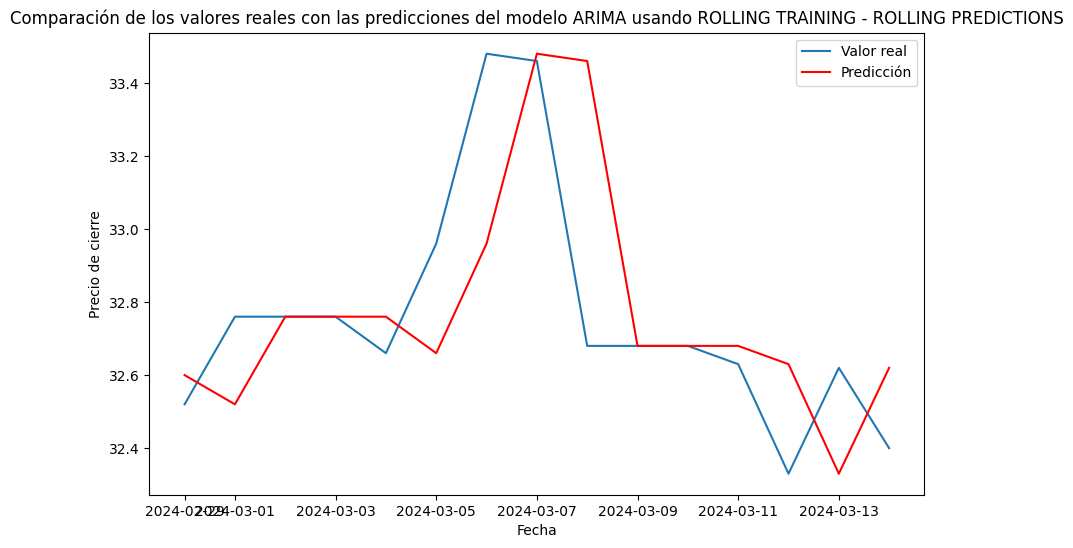

In [25]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df["Close"], label="Valor real")
plt.plot(test_df.index, predictions, color="red", label="Predicción")
plt.title(
    "Comparación de los valores reales con las predicciones del modelo ARIMA usando ROLLING TRAINING - ROLLING PREDICTIONS"
)
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()
plt.show()